# Doc2Vec

In [5]:
import collections
import glob
from itertools import chain
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
%matplotlib inline
np.random.seed(1)

In [6]:
fp = open("articledata.json")
d = json.load(fp)
l = []
for url in d.keys():
    x = {'text': d[url]}
    if d[url]:
        x['url'] = url
        x['label'] = 'Art'
        l.append(x)
df = pd.DataFrame(l)
df

,label,text,url
0,Art,This article is about the academic discipline ...,https://en.wikipedia.org/wiki/Art_history
1,Art,"If you're seeing this message, it means we're ...",https://www.khanacademy.org/humanities/art-his...
2,Art,"If you're seeing this message, it means we're ...",https://www.khanacademy.org/humanities/art-his...
3,Art,"Art history, also called art historiography, h...",https://www.britannica.com/art/art-history
4,Art,"""Why study art history when there are many oth...",https://www.iesa.edu/paris/news-events/art-his...
5,Art,The Definition of Islamic Art\n\nThe objective...,https://apcentral.collegeboard.org/courses/ap-...
6,Art,Building a Context\n\nArchitecture can be a ch...,https://apcentral.collegeboard.org/courses/ap-...
7,Art,"The art of Africa covers a broad region, of co...",http://www.arthistory.net/african-art/


In [9]:
words = []
for f in df['text']:
    words.append(f)

words = list(chain.from_iterable(words))
words = ''.join(words)[:-1]
sentences = words.split('\n')

In [10]:
vocabulary_size = 40000

def build_dataset(sentences):
    words = ''.join(sentences).split()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    unk_count = 0
    sent_data = []
    for sentence in sentences:
        data = []
        for word in sentence.split():
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
        sent_data.append(data)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return sent_data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:2])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 142], ('the', 561), ('of', 474), ('and', 335), ('to', 216)]
Sample data [[45, 552, 8, 59, 1, 364, 124, 2, 6, 172, 73, 16, 553, 2, 1, 13, 2, 6, 1078, 365, 52, 2, 6, 35, 73, 60, 1079, 365, 21, 13, 0], []]


## Tensorflow Model

In [11]:
skip_window = 3
instances = 0

# Pad sentence with skip_windows
for i in range(len(data)):
    data[i] = [vocabulary_size]*skip_window+data[i]+[vocabulary_size]*skip_window

# Check how many training samples that we get    
for sentence  in data:
    instances += len(sentence)-2*skip_window
print(instances)    

10098


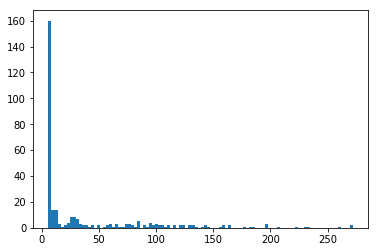

In [12]:
sent_len = np.array([len(d) for d in data])
plt.hist(sent_len,100)
plt.show()

In [13]:
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)
doc = np.zeros((instances,1),dtype=np.int32)

k = 0
for doc_id, sentence  in enumerate(data):
    for i in range(skip_window, len(sentence)-skip_window):
#         buffer = sentence[i-skip_window:i+skip_window+1]
#         labels[k] = sentence[i]
#         del buffer[skip_window]
#         context[k] = buffer
#         doc[k] = doc_id
#         k += 1
        context[k] = sentence[i-skip_window:i+skip_window+1] # Get surrounding words
        labels[k] = sentence[i] # Get target variable
        doc[k] = doc_id
        k += 1
        
context = np.delete(context,skip_window,1) # delete the middle word        
        
shuffle_idx = np.random.permutation(k)
labels = labels[shuffle_idx]
doc = doc[shuffle_idx]
context = context[shuffle_idx]

In [14]:
batch_size = 256
context_window = 2*skip_window
embedding_size = 50 # Dimension of the embedding vector.
softmax_width = embedding_size # +embedding_size2+embedding_size3
num_sampled = 5 # Number of negative examples to sample.
sum_ids = np.repeat(np.arange(batch_size),context_window)

len_docs = len(data)

graph = tf.Graph()

with graph.as_default(): # , tf.device('/cpu:0')
    # Input data.
    train_word_dataset = tf.placeholder(tf.int32, shape=[batch_size*context_window])
    train_doc_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    segment_ids = tf.constant(sum_ids, dtype=tf.int32)

    word_embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    word_embeddings = tf.concat([word_embeddings,tf.zeros((1,embedding_size))],0)
    doc_embeddings = tf.Variable(tf.random_uniform([len_docs,embedding_size],-1.0,1.0))

    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, softmax_width],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_words = tf.segment_mean(tf.nn.embedding_lookup(word_embeddings, train_word_dataset),segment_ids)
    embed_docs = tf.nn.embedding_lookup(doc_embeddings, train_doc_dataset)
    embed = (embed_words+embed_docs)/2.0#+embed_hash+embed_users

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases, train_labels, 
                                         embed, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(doc_embeddings), 1, keep_dims=True))
    normalized_doc_embeddings = doc_embeddings / norm

W0814 19:29:54.971312 4621100480 deprecation.py:323] From /Users/peach/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0814 19:29:55.141247 4621100480 deprecation.py:506] From /Users/peach/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 19:29:55.173512 4621100480 deprecation.py:506] From <ipython-input-14-e83d95f4a36b>:41: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
In

In [15]:
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_doc_data = doc[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_doc_data = np.vstack([doc[data_idx:instances],doc[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data, batch_doc_data

In [16]:
num_steps = 1000001
step_delta = int(num_steps/20)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_word_data, batch_doc_data\
        = generate_batch(batch_size)
        feed_dict = {train_word_dataset : np.squeeze(batch_word_data),
                     train_doc_dataset : np.squeeze(batch_doc_data),
                     train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % step_delta == 0:
            if step > 0:
                average_loss = average_loss / step_delta
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    # Get the weights to save for later
#     final_doc_embeddings = normalized_doc_embeddings.eval()
    final_word_embeddings = word_embeddings.eval()
    final_word_embeddings_out = softmax_weights.eval()
    final_doc_embeddings = normalized_doc_embeddings.eval()

Initialized
Average loss at step 0: 31.925512
Average loss at step 50000: 6.710767
Average loss at step 100000: 1.757895
Average loss at step 150000: 0.768172
Average loss at step 200000: 0.418239
Average loss at step 250000: 0.273582
Average loss at step 300000: 0.213424
Average loss at step 350000: 0.175148
Average loss at step 400000: 0.162720
Average loss at step 450000: 0.151914
Average loss at step 500000: 0.144472
Average loss at step 550000: 0.139787
Average loss at step 600000: 0.136614
Average loss at step 650000: 0.135240
Average loss at step 700000: 0.133735
Average loss at step 750000: 0.132198
Average loss at step 800000: 0.131389
Average loss at step 850000: 0.129497
Average loss at step 900000: 0.129535
Average loss at step 950000: 0.128046
Average loss at step 1000000: 0.127810


In [18]:
rand_doc = np.random.randint(len_docs)
dist = final_doc_embeddings.dot(final_doc_embeddings[rand_doc][:,None])
closest_doc = np.argsort(dist,axis=0)[-4:][::-1]
furthest_doc = np.argsort(dist,axis=0)[0][::-1]

for idx in closest_doc:
    print(dist[idx][0][0])
    
print(dist[furthest_doc][0][0])    

0.9999998
0.31199187
0.28531286
0.2788008
-0.48411837


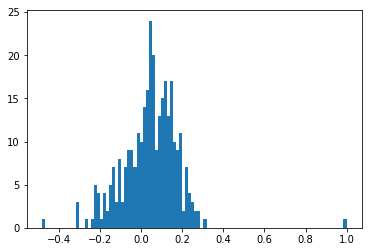

In [19]:
plt.hist(dist,100)
plt.show()

In [20]:
sentences[rand_doc]

''

In [21]:
sentences[closest_doc[1][0]]

'African art has its origins in pre-history. Some rock art recently discovered in South Africa near the Cape may be older than 70,000 years old. The continent is home to a large body of prehistoric rock art. Traditional African art is comprised of art forms such as masks, jewelry, carvings, rock art, sculpture, textiles, metalwork, and much more. Many nations are associated with particular art forms. For example, various peoples of Mali and Cote d’Ivoire are renowned for their traditional masks and headdresses. Tanzania’s Makonde art of fine carving continues to be revered today.'

In [22]:
sentences[closest_doc[2][0]]

'Studying art history is really not about memorizing dates, artists’ names, art movements, etc. Instead, it drives you to analyze paintings, photographs, sculptures, etc. To support your analysis, you must build rational and convincing arguments, hence developing your critical thinking.The Definition of Islamic Art'

In [23]:
sentences[closest_doc[3][0]]

'Art history is not only a biographical endeavor. Art historians often root their studies in the scrutiny of individual objects. They thus attempt to answer in historically specific ways, questions such as: What are key features of this style?, What meaning did this object convey?, How does it function visually?, Did the artist meet their goals well?, What symbols are involved?, and Does it function discursively?'

In [24]:
sentences[furthest_doc[0]]

''

In [31]:
norm_vec[rand_doc].dot(norm_vec[closest_doc[1][0]])

NameError: name 'norm_vec' is not defined

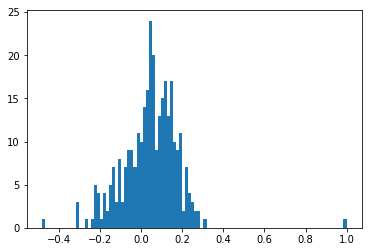

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dist,100)
plt.show()

## Gensim Model

In [26]:
import gensim
from gensim.models import Doc2Vec
from multiprocessing import cpu_count

cpus = cpu_count()

In [27]:
def read_corpus():
    for i,sentence in enumerate(words.split('\n')):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i])

train_corpus = list(read_corpus())

In [28]:
model = Doc2Vec(dm=1, dm_concat=0, size=embedding_size, window=skip_window, 
                negative=5,hs=0, min_count=5, workers=cpus, iter=2)
model.build_vocab(train_corpus)

/Users/peach/miniconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:576: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/peach/miniconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:580: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
W0814 21:07:43.892540 4621100480 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [29]:
%%time
model.train(train_corpus)

ValueError: You must specify either total_examples or total_words, for proper job parameters updationand progress calculations. The usual value is total_examples=model.corpus_count.

In [182]:
closest_doc2 = model.docvecs.most_similar([model.docvecs[rand_doc]],topn=4)
for _, sim in closest_doc2:
    print(sim)

1.0
0.8846234083175659
0.8725295066833496
0.8673354387283325


In [178]:
sentences[rand_doc]

'peter crawford discovers a comet on a collision course with the moon but when the government doesn t believe him dumb fact he builds a shelter in deep underground and is drawing lots to see who will go plus is willing to kill to save humanity dumb fact with millions of dollars of technology how could a civilian see what nasa could not plus the ends justifies the means moral of this story is just plain wrong this movie is improbable and totally unbelievable what was running through these people minds why the hell do crap piles like this get the green light some times i wonder who someone has to to get a movie made in this ing town '

In [179]:
sentences[closest_doc2[1][0]]

'the title of this documentary is very misleading at no time during the documentary do they show how the introduction of the nile perch fish into lake victoria has cause any of the problems facing the town of mwanza tanzania the film tries to place the problems of tanzania on an environmental cause but the truth of that matter is the problems stem from a parasitic outside force the documentary is very slowing paced with no narrative what so ever instead it relies on small blips of text between none related segments to display bits of information that do little to add or expand of the subject matter there are only two attempts to discus the environmental effects of the nile perch fish one is a small segment about seconds long where they interview the factory managers where the fish is processed and he briefly mentions how years ago the nile perch was introduced into the lake and it consumed the other fish species the film maker makes no attempt to follow up on the matter or go deeper in

In [180]:
sentences[closest_doc2[2][0]]

'this could have been great the voice overs are exactly right and fit the characters to a t one small problem though the look of the characters mostly the supporting or guest characters look exactly the same the same bored look on every face only with minor changes such as hairlines or weight size it looks kind of odd to see a really big guest star s voice coming out of a lifeless form like the characters here if i am not mistaken kathy griffin did a voice over for this show and it looked too odd to be funny there is a few other problems one being the family plot the simpsons did it much better where you could actually buy most of the situations the characters got themselves into here we get too much annoying diversions like someone having a weird fantasy and then we are supposed to find that funny but for some reason the delivery is a bit off as you can probably tell it is hard for me to put a finger on exactly what is wrong with this show because it basically nothing more than a clon

In [181]:
sentences[closest_doc2[3][0]]

'i like many folks believe the epic lonesome dove was one of the best westerns ever produced maybe the best and realizing that most sequels in this case a prequel are certain to disappoint my expectations were low comanche moon met that expectation with its marginal directing and acting poor casting and frankly a lousy script lonesome dove created western heroes of captains mccrae and call due to incredibly strong performances by robert duvall and tommy lee jones prior to living in lonesome dove we believed they bravely fought to rid texas of bandits and savage indians during their rangering years if i had only seen comanche moon i would think these two boneheads were a couple of incompetent cowardly idiots in lonesome dove call and mccrae supposedly chased blue duck all over texas and never managed to capture or kill him in comanche moon a shot to call s boot heel convinced him to settle down and raise cattle there wasn t a decent fistfight or gun fight in the entire miniseries the be

(50000, 50)

In [30]:
norm_vec = np.array([vec for vec in model.docvecs])
norm_vec = norm_vec/np.sqrt(np.sum(np.square(norm_vec),axis=1,keepdims=True))

norm_vec[rand_doc].dot(norm_vec[closest_doc[1][0]])

KeyError: "tag '311' not seen in training corpus/invalid"